<a href="https://colab.research.google.com/github/ramansbach/astrophysics_notebooks/blob/main/Week11_12_galaxies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install astropy

In [24]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic,LSR
from astropy.coordinates import Angle, Latitude, Longitude
import astropy.units as u
import numpy as np
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_body_barycentric_posvel

Sirius has celestial coordinates 6 hr 45 min RA and -16° 43' DEC.

In [28]:
siriusc = SkyCoord(ra="06h45m00s", dec="-16d43m00s", frame='icrs')

In [26]:
siriusc

<SkyCoord (ICRS): (ra, dec) in deg
    (101.25, -16.71666667)>

Transform Sirius into Galactic coordinates.

In [27]:
siriusc.transform_to("galactic")

<SkyCoord (Galactic): (l, b) in deg
    (227.21513025, -8.92256526)>

In [29]:
siriuscvel = SkyCoord(ra="06h45m00s", dec="-16d43m00s", radial_velocity=-5.5*u.km/u.s,frame='icrs')

In [30]:
siriuscvel

<SkyCoord (ICRS): (ra, dec) in deg
    (101.25, -16.71666667)
 (radial_velocity) in km / s
    (-5.5,)>

In [33]:
siriuscpm = SkyCoord(ra="06h45m00s", dec="-16d43m00s", pm_ra_cosdec=-546.01*u.mas/u.year,
                     pm_dec=-1223.07*u.mas/u.year,radial_velocity=-5.5*u.km/u.s,frame='icrs')

In [34]:
siriuscpm

<SkyCoord (ICRS): (ra, dec) in deg
    (101.25, -16.71666667)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-546.01, -1223.07, -5.5)>

In [37]:
siriuscpm.transform_to('galactic')

<SkyCoord (Galactic): (l, b) in deg
    (227.21513025, -8.92256526)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (864.01988903, -1023.47289967, -5.5)>

## Getting coordinates from Gaia
Modified from an Astropy tutorial by Adrian Price-Whelan and Stephanie T. Douglas, which may be found here: https://learn.astropy.org/tutorials/gaia-galactic-orbits.html

We will use data from the Gaia mission to get sky positions, distances (parallaxes), proper motions, and radial velocities for a set of stars that are close to the Sun. We will then transform these observed, heliocentric kinematic measurements to Galactocentric Cartesian coordinates

### Installing Dependencies
This tutorial depends on the Astropy affiliated packages gala and astroquery. Both of these packages can be pip-installed with:

`pip install gala astroquery`

In [41]:
! pip install gala astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 36.9 MB/s eta 0:00:00


### Imports

In [42]:
# astropy imports
import astropy.coordinates as coord
from astropy.table import QTable
import astropy.units as u
from astroquery.gaia import Gaia

# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

### Scientific Background

The Gaia mission ( https://www.cosmos.esa.int/web/gaia/) is an ESA mission that aims to measure the 3D positions and velocities of a large number of stars throughout the Milky Way. The primary mission objective is to enable studying the formation, structure, and evolutionary history of our Galaxy by measuring astrometry (sky position, parallax, and proper motion) for about 2 billion stars brighter than the Gaia $G$-band photometric magnitude $G\leq 21$.

 By end of mission (~2025), Gaia will also provide multi-band photometry and low-resolution spectrophotometry for these sources, along with radial or line-of-sight velocities for a subsample of about 100 million stars.

In April 2018, Gaia publicly released its first major catalog of data — data release 2 or DR2 — which provides a subset of these data to anyone with an internet connection. In this tutorial, we will use astrometry, radial velocities, and photometry for a small subset of DR2.

## Using `astroquery` to retrieve Gaia data

We'll start by querying the [Gaia science archive](http://gea.esac.esa.int/archive/) to download astrometric and kinematic data (parallax, proper motion, radial velocity) for a sample of stars near the Sun. We'll use data exclusively from [data release 2 (DR2)](https://www.cosmos.esa.int/web/gaia/data-release-2) from the *Gaia* mission. For the demonstration here, let's grab data for a random subset of 4096 stars within a distance of 100 pc from the Sun that have high signal-to-noise astrometric measurements.

To perform the query and to retrieve the data, we'll use the *Gaia* module in the [astroquery](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html) package, `astroquery.gaia`. This module expects us to provide an SQL query to select the data we want, as we discussed earlier in the semester.

We don't need all of the columns that are available in DR2, so we'll limit our query to request the sky position (`ra`, `dec`), parallax, proper motion components (`pmra`, `pmdec`), radial velocity, and magnitudes (`phot_*_mean_mag`). More information about the available columns is in the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html).

To select stars that have high signal-to-noise parallaxes, we'll use the filter ``parallax_over_error > 10`` to select stars that have small fractional uncertainties. We'll also use the filter ``radial_velocity IS NOT null`` to only select stars that have measured radial velocities.

In [43]:
query_text = '''SELECT TOP 4096 ra, dec, parallax, pmra, pmdec, radial_velocity,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 10 AND
    radial_velocity IS NOT null
ORDER BY random_index
'''

We now pass this query to the `Gaia.launch_job()` class method to create an anonymous job in the `Gaia` science archive to run our query. To retrieve the results of this query as an Astropy `Table` object, we then use the `job.get_results()` method. Note that you may receive a number of warnings (output lines that begin with ``WARNING:``) from the ``astropy.io.votable`` package — these are expected, and it's OK to ignore these warnings.

In [44]:
job = Gaia.launch_job(query_text)
gaia_data = job.get_results()
gaia_data.write('gaia_data.fits')

In [45]:
gaia_data = QTable.read('gaia_data.fits')

The `data` object is now an Astropy `Table` called `gaia_data` that contains `Gaia` data for 4096 random stars within 100 pc (or with a parallax > 10 mas) of the Sun, as we requested. Let's look at the first four rows of the table:

In [46]:
gaia_data[:4]

ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float64,float32,float32,float32
256.8370985186671,46.5081010273448,10.770964834345387,-19.76657104695835,55.92605676622464,-17.673072044811907,12.956912994384766,14.192928314208984,11.859498023986816
129.45826809010867,-6.806694022293258,41.081670013380716,-297.34595349374183,43.83424795415093,35.53814452290586,6.576352119445801,6.931065082550049,6.111272811889648
2.317856723637118,9.00699655780345,17.824765284426462,-171.8278607514459,-1083.8740928197751,-148.91780163518774,13.119074821472168,13.968703269958496,12.223302841186523
330.41287472805976,51.88897801553169,13.0756133009657,-85.30745872006916,-34.23366534215265,-28.726469345049587,12.101919174194336,13.05264949798584,11.149785995483398


Note that the table columns already contain units! They are indicated in the second row of the header.

### Using `astropy.coordinates` to represent and transform stellar positions and velocities

Let's double check that the farthest star is still within 100 pc, as we expect from the parallax selection we did in the query above. To do this, we'll create an Astropy `Distance` object using the parallax (*Note: this inverts the parallax to compute the distance! This is only a good approximation when the parallax signal to noise is large, as we ensured in the query above with `parallax_over_error > 10`*):

In [48]:
dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
dist.min(), dist.max()

(<Distance 8.79909291 pc>, <Distance 99.99985292 pc>)

It looks like the closest star in our sample is about 9 pc away, and the farthest is almost 100 pc, as we expected.

We next want to convert the coordinate position and velocity data from heliocentric, spherical values to Galactocentric, Cartesian values. We'll do this using the [Astropy coordinates](http://docs.astropy.org/en/latest/coordinates/index.html) transformation machinery. To make use of this functionality, we first have to create a `SkyCoord` object from the `Gaia` data we downloaded. The `Gaia` DR2 data are in the ICRS (equatorial) reference frame, which is also the default frame when creating new `SkyCoord` objects, so we don't need to specify the frame below:

In [49]:
c = coord.SkyCoord(ra=gaia_data['ra'],
                   dec=gaia_data['dec'],
                   distance=dist,
                   pm_ra_cosdec=gaia_data['pmra'],
                   pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])

Note: as described in the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html), the Gaia column `pmra` contains the cos(dec) term. In Astropy coordinates, the name of this component is `pm_ra_cosdec`.

Let's again look at the first four coordinates in the `SkyCoord` object:

In [50]:
c[:4]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(256.83709852, 46.50810103, 92.84219338),
     (129.45826809, -6.80669402, 24.3417563 ),
     (  2.31785672,  9.00699656, 56.1017205 ),
     (330.41287473, 51.88897802, 76.47824825)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [( -19.76657105,    55.92605677,  -17.67307204),
     (-297.34595349,    43.83424795,   35.53814452),
     (-171.82786075, -1083.87409282, -148.91780164),
     ( -85.30745872,   -34.23366534,  -28.72646935)]>

Now that we have a `SkyCoord` object with the Gaia data, we can transform to the `Galactic` coordinate system.

In [51]:
c.galactic[:4]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [( 72.32926334,  36.8367097 , 92.84219338),
     (232.07542475,  19.9763116 , 24.3417563 ),
     (105.68646983, -52.44715126, 56.1017205 ),
     ( 98.28701089,  -2.66800849, 76.47824825)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(  55.13035551,   21.88801174,  -17.67307204),
     (-195.30630898, -228.4545973 ,   35.53814452),
     (-455.13470935, -998.57912013, -148.91780164),
     ( -88.74713695,   23.94268239,  -28.72646935)]>

The `Galactic` frame is still centered on the solar system barycenter, whereas we want to compute the positions and velocities of our sample of stars in a Galactocentric frame, centered on the center of the Milky Way. To do this transformation, Astropy provides the `Galactocentric` frame class.

In [53]:
galcen = c.transform_to(coord.Galactocentric())

The `galcen` object now contains the data for our sample, but in the Galactocentric frame:

In [54]:
galcen[:4]

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in pc
    [(-8099.27557969,  70.79989896,  76.40447526),
     (-8136.01292462, -18.04601124,  29.15184863),
     (-8131.33217504,  32.92015736, -23.65310988),
     (-8132.99337545,  75.59768012,  17.26834184)]
 (v_x, v_y, v_z) in km / s
    [(-16.27286222, 233.98501167,   4.96894252),
     (-30.97328868, 226.00094753,  -4.74243368),
     (210.78644085, -11.75804787, -36.5296994 ),
     ( 48.84184119, 222.24147077,  17.69602425)]>

We can access the positions of the stars using the `.x`, `.y`, and `.z` attributes, for example:

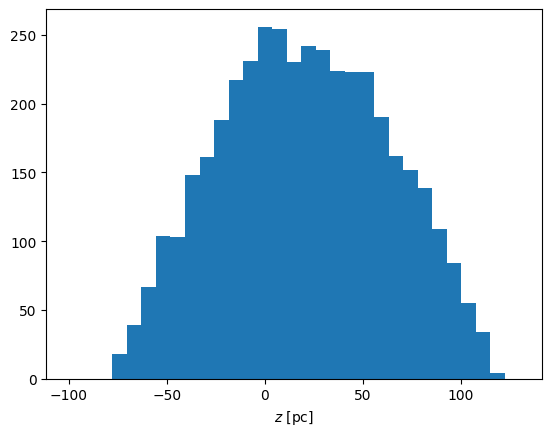

In [56]:
plt.hist(galcen.z.value, bins=np.linspace(-100, 130, 32))
plt.xlabel('$z$ [{0:latex_inline}]'.format(galcen.z.unit));

Similarly, for the velocity components, we can use `.v_x`, `.v_y`, and `.v_z`. For example, to create a classic "UV" plane velocity plot:

Text(0, 0.5, '$v_y$ [$\\mathrm{km\\,s^{-1}}$]')

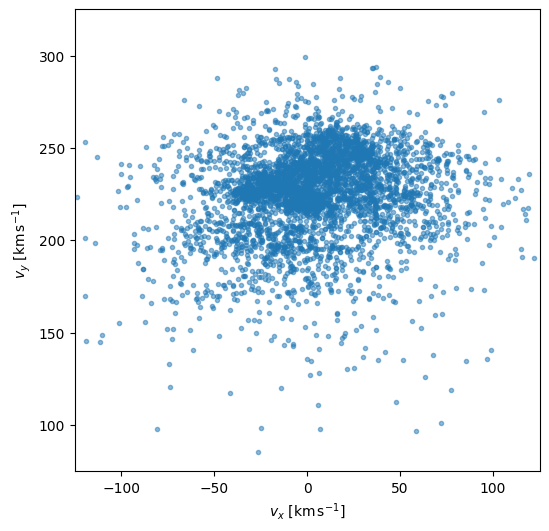

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(galcen.v_x.value, galcen.v_y.value,
        marker='.', linestyle='none', alpha=0.5)

ax.set_xlim(-125, 125)
ax.set_ylim(200-125, 200+125)

ax.set_xlabel('$v_x$ [{0:latex_inline}]'.format(u.km/u.s))
ax.set_ylabel('$v_y$ [{0:latex_inline}]'.format(u.km/u.s))